## Principe

Informations données par Sophie


<img src="./sophie1.png" />

<img src="./sophie2.png" />

L'énergie de la sheet serait donc donnée par:

$$E_p=\sum_{e} -\frac{\epsilon_0}{2}l_e C_e^2 - \epsilon_1 l_e C_e C_{\hat{e}} 
-\frac{J}{2}\left( (C_e - C_{v1})^2 + (C_{e} -C_{v2})^2     \right)$$

où $e$ parcourt les edges, $\hat{e}$ est le edge complémentaire de $e$, $v1,v2$ sont les vertexs voisins de e.

Quote Sophie:

*Le premier terme est l’auto enrichissement de la protéine sur un edge. Le second terme est l’enrichissement sur le demi edge opposé (soit sur la cellule d’en face). Le troisième terme est la diminution des protéines sur les vertex voisins.*

*Il y a aussi deux contraintes : - la quantité de protéine sur un edge est toujours positive - la quantité de protéine dans une cellule est constante*

**mais** dans la définition de $E_p$ ci-dessus, il n'y a que des termes négatifs (favorable au min), et pas de termes contributifs (des pénalités), donc il n'y a pas de minimum et la solution va vers une explosion de la densité de protéine...

Je remets la contrainte sur la limitation de l'augmentation en prot A de Sophie (P4):

$$P4 = \lambda_c \sum_f \left( \sum_{e\, in\, f} l_e C_e - Q_f^*\right)^2$$

où $f$ parcourt les faces (les cellules), et $Q_f^*$ est la quantité "cible" de protéine pour la cellule $f$.

# Program

In [104]:
import os
import time
import sys
import json
import copy
import math
import numpy as np
import ipyvolume as ipv
import pathlib
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt

import tyssue
import tyssue.dynamics
import tyssue.dynamics.factory
import tyssue.stores
import tyssue.config.geometry
import tyssue.io
import tyssue.draw
import tyssue.draw.plt_draw

import scipy
import scipy.optimize

Verbose = False

%matplotlib inline

SIM_DIR = pathlib.Path('.')

#from polarity.solver import find_energy_min

## Init 

### On charge une configuration à 15 cellules
Définit sheet, une structure contenant : des vertex, des edges, des faces.
On est en 2D, chaque face est une cellule.
Les frontières entre deux cellules sont données par deux "demi-"edges, un par cellule.

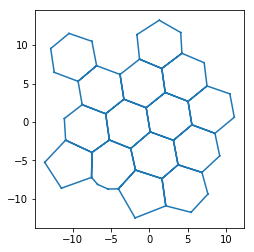

In [105]:
h5store = os.path.join(tyssue.stores.stores_dir, "15_cells_patch.hf5")

datasets = tyssue.io.hdf5.load_datasets(
    h5store, 
    data_names=["face", "vert", "edge"])

specs = tyssue.config.geometry.cylindrical_sheet()
sheet = tyssue.Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = tyssue.draw.plt_draw.quick_edge_draw(
    sheet, 
    coords=list('xy'))

### On ajoute une colone prefered_N_a aux faces, indique la qté totale de protein a dans la cellule

In [106]:
## Add column 'C_a' to face_df, which contains the total 
## quantity of protein a in the cell
sheet.face_df['prefered_N_a'] = 1


### On ajoute à chaque edge : une colonne C_a, qté de protein a sur ce edge
La quantité de a est donnée en densité par mètre, elle est randomisée par edge, et la somme totale sur chaque cell est son 'prefered_N_a'.

In [107]:
## rand entre 0 et 0.3 sur chaque edge
sheet.edge_df['N_a'] = np.random.uniform(low=0.0, high=0.3, size=sheet.Ne) 
## on normalise par face
faces_N_a = sheet.sum_face(sheet.edge_df['N_a'])
sheet.edge_df['N_a'] = (sheet.edge_df['N_a'] 
    * sheet.upcast_face(sheet.face_df['prefered_N_a']/faces_N_a['N_a']))
## en densité => qté par longueur de edge
sheet.edge_df['C_a'] = sheet.edge_df['N_a'] / sheet.edge_df.length
if Verbose: 
    print("qté prot par cell")## check
    print(sheet.sum_face(sheet.edge_df['N_a'])) ## ok


In [108]:
if Verbose:
    print("sheet.datasets.items()")
    print(sheet.datasets.items())

## RUN

**Procedure 'robuste' (JG)**

Le minimizeur est SLSQP avec bounds $[0..\infty]$ sur les $C_e$, mais sans utiliser le gradient (jacobian) ni linear constraints.

**codes de Sophie**

le chem_energy effectivement utilisé est redéfini plus bas: *chem_energyJG*

*chem_energyJG* utilise tel quel *_calculate_diff_C_neighbors* 
 non analysé par JG

In [115]:
keepEnergy=[]
keepP1=[]
keepP2=[]
keepP3=[]
keepP4=[]
keepP5=[]

def _calculate_diff_C_neighbors(sheet):
    C1_ij = sheet.edge_df.sort_values(['face', 'trgt'])['C_a']
    C1_jm = sheet.edge_df.sort_values(['face', 'srce'])['C_a']
    couple1 = pd.DataFrame(
        {'ij': C1_ij.values, 'jm': C1_jm.values}, index=C1_ij.index)
    diff_couple1 = couple1['ij'] - couple1['jm']
    diff_couple1.sort_index(axis='index', inplace=True)

    C2_ij = sheet.edge_df.sort_values(['face', 'srce'])['C_a']
    C2_ni = sheet.edge_df.sort_values(['face', 'trgt'])['C_a']
    couple2 = pd.DataFrame(
        {'ij': C2_ij.values, 'ni': C2_ni.values}, index=C2_ij.index)
    diff_couple2 = couple2['ij'] - couple2['ni']
    diff_couple2.sort_index(axis='index', inplace=True)

    return (diff_couple1, diff_couple2)

def chem_energy(c, sheet): 
    
    ## def set_concentration(sheet, c):    
    sheet.edge_df['C_a'] = c
    sheet.edge_df['N_a'] = sheet.edge_df['C_a'] * sheet.edge_df['length']
    
    LesNa = c*sheet.edge_df['length']

    # Auto enrichissement
    P1 = (- sheet.settings['epsilon_0'] / 2 *
          sheet.edge_df['length'] * sheet.edge_df['C_a']**2).values
    P1s = P1.sum()

    # Enrichissment in the edge of the opposite cell
    sheet.get_opposite()
    P2 = (- sheet.settings['epsilon_1'] * sheet.edge_df['length'] * sheet.edge_df[
          'C_a'] * tyssue.utils.data_at_opposite(sheet, sheet.edge_df['C_a'], 0)).values
    P2s = P2.sum()

    # Depletion on next edge
    diff_couple1, diff_couple2 = _calculate_diff_C_neighbors(sheet)
    P3 = - sheet.settings['J'] / 2 * (diff_couple1**2 + diff_couple2**2)
    P3s = P3.sum()
    
    # Logarithmic term
    Te = 25
    P4 = []
    for i in range (0, sheet.Ne) : 
        if sheet.edge_df['C_a'][i] == 0 : 
            sheet.edge_df['C_a'][i]=0.01
        #print(sheet.edge_df['C_a'][i])
        P4.append(sheet.edge_df['length'][i]*sheet.edge_df['C_a'][i]*math.log(sheet.edge_df['C_a'][i]))
    
    #P4 = [Te*sheet.edge_df['length'][i]*sheet.edge_df['C_a'][i]*math.log(sheet.edge_df['C_a'][i]) 
    #      for i in range (0, sheet.Ne)]
    P4s = Te*sum(P4)

    # Constraint on concentration
    P5 = (sheet.settings['lambda_c'] * (sheet.sum_face(sheet.edge_df['C_a'])['C_a'] - sheet.face_df['prefered_N_a']*sheet.face_df['perimeter'])**2)
    P5s = P5.sum()
       
    EnergyTotale = P1s + P2s + P3s + P4s + P5s
    
    ## keep track
    keepEnergy.append(EnergyTotale)
    keepP1.append(P1.sum())
    keepP2.append(P2.sum())
    keepP3.append(P3.sum())
    keepP4.append(sum(P4))
    keepP5.append(P5.sum())
    
    return EnergyTotale

#### Keep a copy of the initial sheet
 so that we can try several times the bloc below with no need to run each time the whole thing from the start
 
 The copy is also used to make compared graphics in the end

In [110]:
InitialSheet = copy.deepcopy(sheet)

#### Minimize

In [116]:
## Restart from the initial config
sheet = copy.deepcopy(InitialSheet)
## initial guess
c0 = sheet.edge_df['C_a']
## parametres
sheet.settings ['epsilon_0'] = 1
sheet.settings ['epsilon_1'] = 1
sheet.settings ['J'] =  1e-6
sheet.settings ['lambda_c'] = 3

print("Wait...")

res = scipy.optimize.minimize(
        fun=chem_energy, ## fonction à minimiser
        x0=c0, ## initial guess
        method='SLSQP', ##method='L-BFGS-B', ## method='Nelder-Mead',
        bounds= scipy.optimize.Bounds(np.zeros(sheet.Ne), np.full((sheet.Ne), np.inf)),
        tol=1e-3,
        options={'maxiter':10000},
        args=(sheet) ## args passed to chem_energy
        ) 

print("succes : ",res['success'])

## print(res)
DiffCas = np.array(sheet.edge_df.C_a - InitialSheet.edge_df.C_a)
print("Edges final")
print(np.array(sheet.edge_df.C_a))
## print("Diff Final-Initial")
## print(DiffCas)
print("quantité par cell")
print(np.array(sheet.sum_face(sheet.edge_df['N_a'])['N_a']))
print("somme totale")
print(sheet.sum_face(sheet.edge_df['N_a'])['N_a'].sum())

Wait...


/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


succes :  True
Edges final
[1.02955279 1.00318331 1.19561313 1.08965156 1.08787384 1.03693885
 1.07123708 1.08099238 1.09856179 1.09871068 1.05312416 1.06194552
 0.97291746 1.02683114 1.07793202 0.92693428 0.98693002 1.10143331
 1.11250457 0.98933957 1.0232446  0.99638971 0.97503386 0.97845639
 1.04275148 1.10436889 1.11990913 1.008487   1.12573819 1.11108278
 1.08542594 1.0828305  0.96844596 1.0231739  1.10310782 1.09267524
 1.07924871 1.08771821 1.0621063  1.06153308 1.08051673 1.07464842
 1.05697863 1.06317029 1.05711936 1.05401516 1.15350706 1.14524396
 1.11478625 1.11256898 1.02494238 1.0308181  0.99533828 0.99890978
 1.13406319 0.85599318 1.06520906 1.0546991  1.30086925 1.27444609
 1.06002195 0.95141475 0.88477972 1.17797436 0.98350404 1.07814115
 0.84280392 1.15251195 0.79876046 0.83017244 1.1843674  0.80955128
 0.86779057 1.02121774 0.92297703 0.89832014 0.90559543 1.12913502
 0.91221057 1.23537081 0.94348894 1.67886262 1.94956036 2.40036557
 0.99947981 1.09718357 0.98732872 1

## Results

### Evolutions des énergies
Les plots montrent que la descente d'énergie converge.

Avec le jeu de paramètres utilisés ($J=10^{-6}$), le composant P3 contribue très peu à l'énergie.

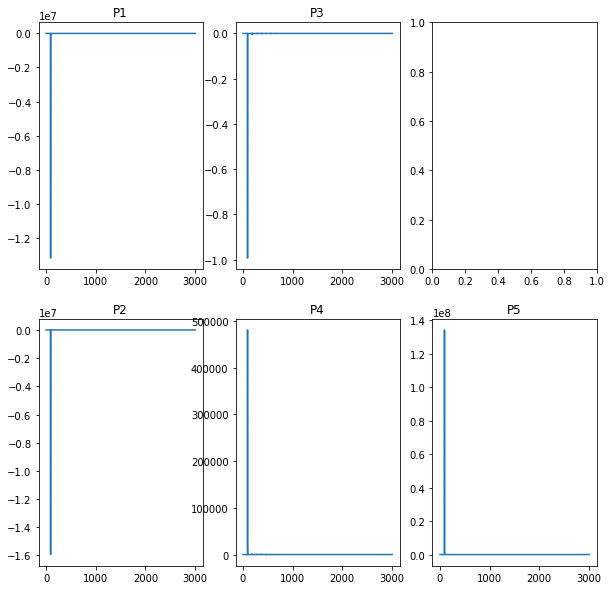

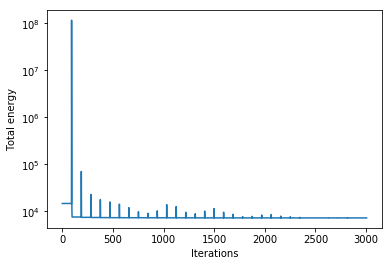

In [117]:
fig, axs = plt.subplots(2, 3, figsize=[10, 10])
axs[0,0].plot(keepP1)
axs[0,0].set_title('P1')
axs[1,0].plot(keepP2)
axs[1,0].set_title('P2')
axs[0,1].plot(keepP3)
axs[0,1].set_title('P3')
axs[1,1].plot(keepP4)
axs[1,1].set_title('P4')
axs[1,2].plot(keepP5)
axs[1,2].set_title('P5')
## fig.tight_layout()
plt.show()

plt.plot(keepEnergy)
plt.ylabel("Total energy")
plt.xlabel("Iterations")
plt.yscale("symlog")
plt.show()

### Evolutions des C_a sur les edges

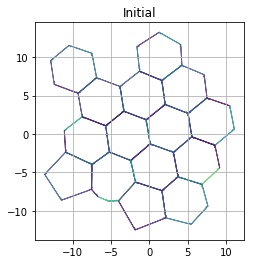

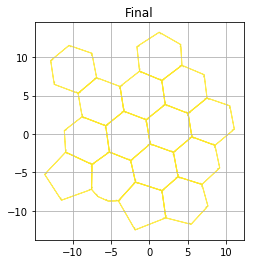

In [118]:
sheet2 = InitialSheet.extract_bounding_box(
    y_boundary=[-100,100], 
    x_boundary = [-200,200], 
    z_boundary=[-400,400])
fig, ax = tyssue.draw.sheet_view(sheet2, 
            edge={'color_range': [0,0.2],'color':sheet2.edge_df.C_a, 'width':1}, 
            vert={'visible':False}, coords = ['x','y'])
ax.set_title('Initial')
sheet2 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-20,20], z_boundary=[-40,40])
fig, ax = tyssue.draw.sheet_view(sheet2, 
            edge={'color_range': [0.,0.2],'color':sheet2.edge_df.C_a, 'width':1}, 
            vert={'visible':False}, coords = ['x','y'])
ax.set_title('Final')
plt.show()

Il y a quelques edges qui ont monté en concentration, et d'autres qui se sont vidés: on obtient bien une répartition bimodale des concentrations.

### Histogramme des concentrations
Initial : random, Final : bimodal

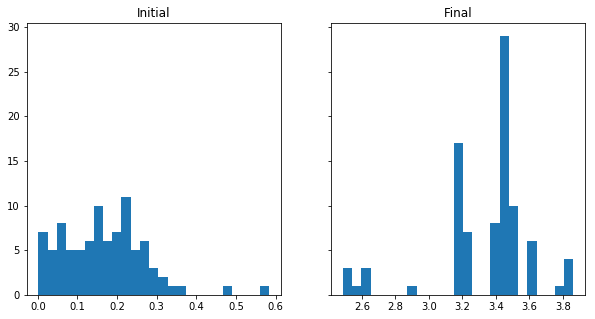

In [119]:
n_bins=25
fig, axs = plt.subplots(1, 2, sharey=True, figsize=[10, 5])
axs[0].hist(InitialSheet.edge_df.C_a*InitialSheet.edge_df.length, bins=n_bins)
axs[0].set_title('Initial')
axs[1].hist(sheet.edge_df.C_a*sheet.edge_df.length, bins=n_bins)
axs[1].set_title('Final')
plt.show()

## Analyses...

### Comparaison $C_e$ final vs $C_e$ initial

Pas de corrélation apparente

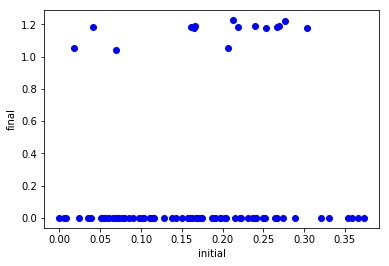

In [13]:
plt.plot(InitialSheet.edge_df['N_a'],sheet.edge_df['N_a'],'bo')
plt.xlabel("initial")
plt.ylabel("final")
plt.show()

### Comparaison $C_e$ final vs $l_e$, length of the edge

Pas de corrélation apparente

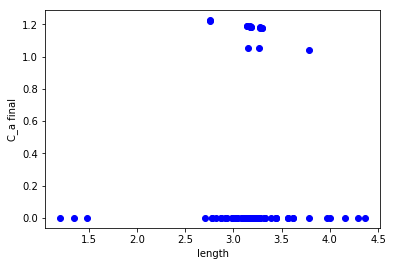

In [14]:
plt.plot(sheet.edge_df['length'],sheet.edge_df['N_a'],'bo')
plt.xlabel("length")
plt.ylabel("C_a final")
plt.show()

## Commentaires

Si on a bien des edges qui monopolisent la prot, en revanche, on ne voit pas de polarité intra-cellulaire ; si l'inhibition mutuelle est seulement entre edges voisins de même vertex, ça semble plutôt attendu.
Pour induire une polarisation, il faudrait ajouter une pénalité de type "inhibition avec le edge d'en face", mais à voir si ça suffirait.

Les résultats sur la quantité par cell montre que l'algo ne *garantit pas* la conservation de la quantité de prot par cellule : on met une pénalité dessus, mais ce n'est pas une contrainte absolue. 

JG ne sait pas comment introduire une contrainte absolue dans une approche de type minimization d'énergie.

Pour la concentration finale vs. la concentration initiale: il ne semble pas y avoir de corrélation.

Pour la concentration finale vs la longueur, il ne semble pas y avoir non plus de corrélation. A comparer avec le modèle du papier de Salbreux où il y a une corrélation entre la longueur des edges et la concentration : les cellules sont allongées, et comme ce sont les edges courts qui gagnent en concentration, c'est ça qui installe la polarisation.

Ca semble crucial pour leur packing. 

Ici, pas de corrélation visible entre longueur et concentration : peut-être ajouter un élément dans l'énergie effective pour favoriser cela ?
Possibilité: partir d'une configuration où les cellules sont déjà allongées, et vérifier que ce sont bien les edges courts qui gagnent.